In [109]:
import pandas as pd
import numpy as np 
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.functional as F

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams["figure.dpi"] = 100

In [3]:
# Load the dataset
file_path = 'training_data.csv'
data = pd.read_csv(file_path)
data['increase_stock_binary'] = data['increase_stock'].apply(lambda x: 1 if x == 'high_bike_demand' else 0)

# Display the first few rows of the dataframe
data.head()

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock,increase_stock_binary
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.0,0,0.0,16.3,31.6,16.0,low_bike_demand,0
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.0,0,0.0,23.9,85.7,16.0,low_bike_demand,0
2,21,3,8,0,1,1,26.9,21.8,73.39,0.0,0,0.0,0.0,81.1,16.0,low_bike_demand,0
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.0,0,0.0,19.2,0.0,16.0,low_bike_demand,0
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.0,0,0.0,10.5,44.6,16.0,low_bike_demand,0


In [17]:
X = data.to_numpy()
X = np.concatenate([X[:,:-2], X[:,-1:]], axis=-1)
print(X.shape)

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

y = X[:,-1].astype(float)
X = X[:,:-2].astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, random_state=0, shuffle=True)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)[:,None]
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)[:,None]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(1600, 16)


(torch.Size([1000, 14]),
 torch.Size([600, 14]),
 torch.Size([1000, 1]),
 torch.Size([600, 1]))

100%|██████████| 500/500 [00:02<00:00, 225.34it/s]

0.8883333333333333


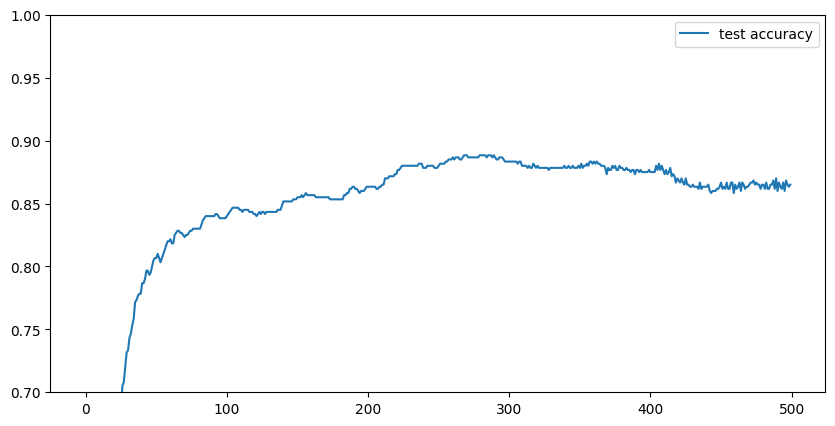

In [119]:
class Model(nn.Module):
    def __init__(self, hidden_size, input_size, output_size, layers=2):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size
        
        self.activation = nn.ReLU()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.batch_norm_input = nn.BatchNorm1d(hidden_size)  # BatchNorm for input layer
        self.linear_layers = nn.ModuleList()
        self.batch_norm_layers = nn.ModuleList()  # BatchNorm for other layers

        for _ in range(layers):
            self.linear_layers.append(nn.Linear(hidden_size, hidden_size))
            self.batch_norm_layers.append(nn.BatchNorm1d(hidden_size))

        self.output_layer = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.batch_norm_input(x)  # Apply BatchNorm after input layer
        x = self.activation(x)

        for layer, batch_norm in zip(self.linear_layers, self.batch_norm_layers):
            residual = x
            x = layer(x)
            x = batch_norm(x)  # Apply BatchNorm after each linear layer
            x = self.activation(x + residual)  # Residual connection

        x = self.output_layer(x)
        x = torch.sigmoid(x)  # It's more common to use torch.sigmoid here
        return x

    
model = Model(17, X_train.shape[-1], y_train.shape[-1], 2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss() 

metric = lambda prediction, label: (prediction.round() == label).numpy().mean()
        
epochs = 500
train_loss_history = []
test_loss_history = []
test_metric_history = []

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    
    with torch.no_grad():
        y_pred = model(X_test)
        test_loss = loss_fn(y_pred, y_test)
        test_loss_history.append(test_loss.item())
        accuracy = metric(y_pred, y_test)
        test_metric_history.append(accuracy)
        
    train_loss_history.append(loss.item())
    loss.backward()
    optimizer.step() 


plt.figure(figsize=(10, 5), dpi=100)
#plt.plot(train_loss_history, label="train loss")
#plt.plot(test_loss_history, label="test loss")
plt.plot(test_metric_history, label="test accuracy")
plt.ylim(0.7, 1)
print(max(test_metric_history))
plt.legend()

In [114]:
epochs = 200
def objective(trial):
    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 10, 500)
    layers = trial.suggest_int('layers', 1, 20)

    # Define model
    model = Model(hidden_size, X_train.shape[-1], y_train.shape[-1], layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.BCELoss()
    test_metric_history = []

    # Training loop
    for epoch in tqdm(range(epochs)):
        optimizer.zero_grad()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        loss.backward()
        optimizer.step()

        # Evaluation (for example, accuracy)
        with torch.no_grad():
            y_pred = model(X_test)
            accuracy = metric(y_pred, y_test)
            test_metric_history.append(accuracy)

    return np.max(accuracy) 

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

print(study.best_trial)


[I 2023-11-13 14:18:09,512] A new study created in memory with name: no-name-4dd84a08-08ef-4f22-a1f8-b200f9ab5c5f
100%|██████████| 200/200 [00:06<00:00, 30.36it/s]
[I 2023-11-13 14:18:16,342] Trial 0 finished with value: 0.8566666666666667 and parameters: {'hidden_size': 157, 'layers': 6}. Best is trial 0 with value: 0.8566666666666667.
100%|██████████| 200/200 [00:10<00:00, 19.34it/s]
[I 2023-11-13 14:18:26,694] Trial 1 finished with value: 0.8383333333333334 and parameters: {'hidden_size': 459, 'layers': 2}. Best is trial 0 with value: 0.8566666666666667.
100%|██████████| 200/200 [00:02<00:00, 90.95it/s]
[I 2023-11-13 14:18:28,905] Trial 2 finished with value: 0.825 and parameters: {'hidden_size': 30, 'layers': 6}. Best is trial 0 with value: 0.8566666666666667.
100%|██████████| 200/200 [00:05<00:00, 36.65it/s]
[I 2023-11-13 14:18:34,371] Trial 3 finished with value: 0.8316666666666667 and parameters: {'hidden_size': 139, 'layers': 6}. Best is trial 0 with value: 0.8566666666666667.


FrozenTrial(number=465, state=TrialState.COMPLETE, values=[0.8916666666666667], datetime_start=datetime.datetime(2023, 11, 13, 14, 56, 30, 924158), datetime_complete=datetime.datetime(2023, 11, 13, 14, 56, 32, 117906), params={'hidden_size': 17, 'layers': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_size': IntDistribution(high=500, log=False, low=10, step=1), 'layers': IntDistribution(high=20, log=False, low=1, step=1)}, trial_id=465, value=None)


## Conclusion
The best model has two layers each with 17 units.